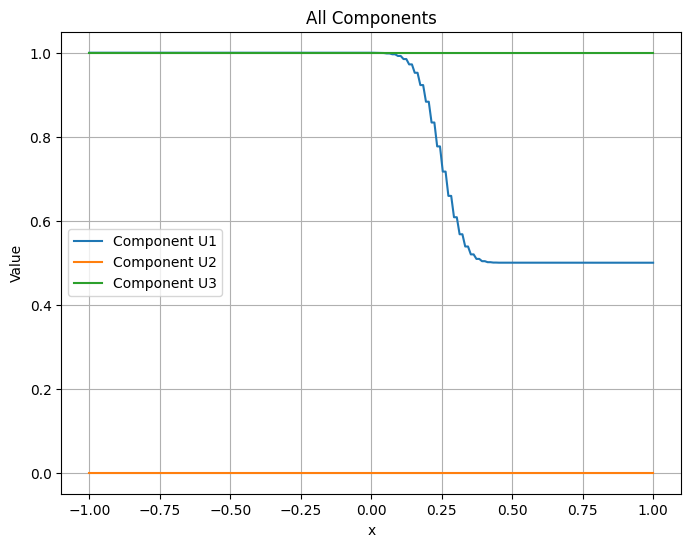

In [8]:
import numpy as np
import matplotlib.pyplot as plt


L = -1.0  
R = 1.0   
T = 0.25 
N = 200
dx = (R - L) / N 
dt =  0.9*dx / 2 

A = np.array([[1, 0, -1],
              [0, 2, 1],
              [0, 1, 0]])

x = np.linspace(L, R, N + 2) 
nt = int(T / dt)  

#Initial condition taken in the Array 
U = np.zeros((N + 2, 3))  # N+2 for lax_friedrichs scheme 
UL = np.array([1, 0, 1])  
UR = np.array([0.5, 0, 1])  
U[x < 0, :] = UL
U[x >= 0, :] = UR

def flux(U):
    return np.dot(A, U.T).T

def lax_friedrichs(U, dt, dx):
    U_new = np.zeros_like(U)
    for i in range(1, N + 1):
        U_new[i] = 0.5 * (U[i + 1] + U[i - 1]) - (dt / (2 * dx)) * (flux(U[i + 1]) - flux(U[i - 1]))
    U_new[0] = U_new[1]
    U_new[-1] = U_new[-2]
    return U_new



for _ in range(nt):
    U = lax_friedrichs(U, dt, dx)



# Affichage des résultats
components = ['U1', 'U2', 'U3']
# didnt succeed in finding the exact soltion

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(3):
    ax.plot(x, U[:, i], label=f"Component {components[i]}", linestyle="-")

ax.set_title("All Components")
ax.set_xlabel("x")
ax.set_ylabel("Value")
ax.legend()
ax.grid()

plt.show()




I didn't find how to compute exact soltuion, but if we take a look at  we have for U_1 : 1 -> 0.5 ; U_2 -> 0-> 0 ; U_3 : 1 -> 1

In [9]:
#EXO2 
import numpy as np
import matplotlib.pyplot as plt

g = 9.81  # gravité

def Z(a,b):
    if b < a:
        return 2*np.sqrt(g)*1/(np.sqrt(a)+np.sqrt(b))
    else : 
        return np.sqrt(g/2)*np.sqrt(1/a+1/b)

def DZ(a,b):
    if b < a :
        return 2*np.sqrt(g)*-1/(2*np.sqrt(b))*1/((np.sqrt(a)+np.sqrt(b))**2)
    else:
        return np.sqrt(g/2)*-1/(2*b**2*(np.sqrt(1/a+1/b)))
    

#solver newton for hm
def solve_height(hL, hR, uL, uR, tol=1e-6, max_iter=100):
    def f(hm):
        return uR - uL  -(hm-hL)*Z(hL,hm) -(hm-hR) * Z(hR,hm)

    h = (hL + hR) / 2  #
    for i in range(max_iter):
        h_new = h - f(h) / DZ(hL,h)
        if abs(h_new - h) < tol:
            return h_new
        h = h_new
    return h

#characteristic speed
def lambda_1(u,h):
    return u - np.sqrt(g*h)

def lambda_2(u,h):
    return u + np.sqrt(g*h)



# Solveur exact de Riemann
def riemann_solver(hL, hR,uL, uR,x):
    def U(x,h):
        if x < lambda_1(uL,h):
            return uL
        elif x > lambda_2(uR,h):
            return uR
        else :
            return x # i didnt understand how to compute the V fonction
    u = 0
    hm = solve_height(hL, hR, uL, uR)
    um = uL - (hm-uL)*Z(hL,hm)
    vm = uR - (hm - uR)*Z(hR,hm)

    if hm < hL:
        v1_minus = lambda_1(uL,hm)
        v1_plus = v1_minus
    else :
        v1_minus = lambda_1(uL,hm)
        v1_plus = lambda_1(uR,hm)
    
    if hm < hR:
        v2_minus = lambda_2(uL,hm)
        v2_plus = v2_minus
    else :
        v2_minus = lambda_2(uL,hm)
        v2_plus = lambda_2(uR,hm)
    
    if x < v1_minus:
        return uR
    
    elif v1_minus < x < v1_plus:
        return U(u- np.sqrt(g*hm))

    elif v1_plus < x < v2_minus:
        return um 
    
    elif v2_minus < x < v2_plus:
        return U(u + np.sqrt(g*hm)) #i didnt understand what represent U here 
    
    else :
        return uR




In [10]:
#Exercice 3 

gamma = 2.0  
kappa = 1.0  

def sound_speed( rho ):
    p = kappa * rho**gamma
    dp_drho = gamma * kappa * rho**(gamma - 1)
    return np.sqrt(dp_drho)

# Riemann solver for the HLL scheme
def HLL_flux(UL, UR,x):
    rho_L, u_L = UL
    rho_R, u_R = UR

    c_L = sound_speed(rho_L)
    c_R = sound_speed(rho_R)

    S_L = min(u_L - c_L, u_R - c_R)
    S_R = max(u_L + c_L, u_R + c_R)
    
    def flux(rho,u):
        p=  kappa * rho ** gamma
        return np.array([rho *u,rho * u**2 + p])
    
    Fl = flux(rho_L,u_L)
    Fr = flux(rho_R,u_R) 
 
    if x <= S_L:
        return UL
    
    elif x >= S_R:
        return UR
    
    else:
        return (S_R *UR - S_L*UL + Fl - Fr )/ (S_R-S_L) 




C:\Users\axeld\AppData\Local\Temp\ipykernel_30988\1525020882.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(dp_drho)


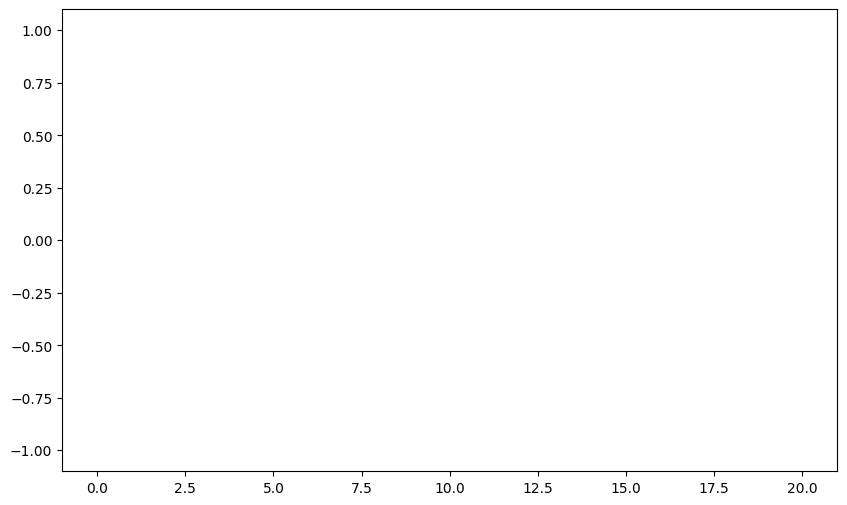

In [17]:
def finite_volume_solver(n_cells, t_final,  dx, UL, UR):
  
    U = np.zeros((n_cells, 2))  

    mid = n_cells//2 
    
    U[0:mid,] = UL
    U[mid:,] = UR
    dt = 0.5*dx/ (np.max(np.abs(U[:,1]/U[:,0]))) *0.05
    n_steps = int(t_final / dt)
    for t in range (1,n_steps):
        U_new = np.copy(U)
        
        for i in range (1,n_cells-1):
            x = dx*i/(dt*t)

            flux_L = HLL_flux(U[i-1], U[i],x)
            flux_R = HLL_flux(U[i], U[i+1],x)
            U_new[i,0] = U[i,0] - dt / dx * (flux_R[0] - flux_L[0])
            U_new[i,1] = U[i,1] - dt / dx * (flux_R[1] - flux_L[1])
        
        U = np.copy(U_new)
            

    return U


n_cells = 200  
t_final = 0.2  
dx = 0.1  
dt = 0.01  


UL = np.array([1.0, -1.0])  # Left state
UR = np.array([0.25, 1.0])  # Right state


U = finite_volume_solver(n_cells, t_final, dx, UL, UR)


x = np.linspace(0, n_cells * dx, n_cells)
plt.figure(figsize=(10, 6))
plt.plot(x, U[:, 0])
plt.plot(x, U[:, 1])
plt.show()

Some issue seems to appears in the result 